# Part2. 예제 1번
---
사람 손글씨 데이터 (MNIST)를 이용해 MLP 설계하기  
MLP 모델 설계 순서는 다음과 같음
1. 모듈 임포트
2. 딥러닝 모델 설계 시 활용하는 장비 확인
3. MNIST 데이터 다운로드 (train, test split)
4. 데이터 확인하기 (1)
5. 데이터 확인하기 (2)
6. MLP (Multi Layer Perceptron) 설계
7. Optimizer, Objective Function 설정
8. MLP 모델 학습 시 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
9. 학습 과정에서 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의
10. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인


## 1.모듈 import
---

In [4]:
'''1. Module Import'''
import numpy as np                              # numpy
import matplotlib.pyplot as plt                 # 시각화
import torch                                    # torch 기본 모듈
import torch.nn as nn                           # 인공 신경망 모델 설계시 필요한 함수를 모아 놓음 (neural network)
import torch.nn.functional as F                 # 자주 이용되는 functional 함수 
from torchvision import transforms, datasets    # torchvision의 transforms, datasets

## 2.딥러닝 모델 설계 시 장비 확인
---

In [5]:
'''2. 딥러닝 모델을 설계할 때 활용하는 장비 확인'''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(f"Using PyTorch version: {torch.__version__}  Device: {DEVICE}")

Using PyTorch version: 1.10.1  Device: cuda


In [6]:
# 하이퍼 파라미터 세팅은 보통 영어 대문자로 표기
BATCH_SIZE = 32
EPOCHS = 10

### **BATCH와 EPOCHS**

---

- **<span style="color:green">BATCH_SIZE</span>**
    - MLP 모델 학습 시 필요한 데이터 개수의 단위
    - Mini-Batch 1개 단위에 대해 데이터가 32개로 구성되어 있음을 의미함
        > MLP 모델 학습 시에 32개 데잍로 첫 번째 학습을 수행하고, <br>
        > 그 다음 32개의 데이터를 이용해 두 번째로 학습
    - $1\,Mini\,Batch = 32\,datas$
    - 1개의 Mini-Batch를 이용해 학습하는 횟수를 <span style="color:magenta">iteration</span>
    - 전체 데이터를 이용해 학습을 진행한 횟수 <span style="color:magenta">Epoch</span>
        ```text
        예를 들어, 전체 데이터 10,000개, 1,000개의 데이터를 이용해 Mini-Batch를 구성한다면
        1Epoch당 10회의 Interation이 발생
        ```
    - Mini-Batch의 데이터 개수(BATCH_SIZE)와 Epoch를 지정하면 Iteration은 전체 데이터 개수에서 BATCH_SIZE로 나눠준 몫 만큼 Interation 진행  
<br>
- **<sapn style="color:green">Epoch</span>**
    - Mini-Batch 1개 단위로 Back Propagation을 이용해 MLP의 가중값을 업데이트
    - Epoch는 존재하고 있는 Mini-Batch를 전부 이용하는 횟수를 의미

> 예시) Datas = 10000, BATCH_SIZE = 100, Epoch = 20 일 때 <br>
> 한 Mini-Batch 당 100개의 데이터가 활용 되므로 iteration = 100 <br>
> 1 Epoch 당 100개의 iteration이 존재하므로 (총 학습 횟수) = 20*100 = 2000

## 3.MNIST 데이터 다운로드 (Train, Test split)
---

In [7]:
'''3. MNIST 데이터 다운로드 (Train, Test split)'''
train_dataset = datasets.MNIST(root = "./data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "./data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

---

```python
train_dataset = datasets.MNIST(root = "./data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())
```
- MNIST Datasets Downloads
    - `root` : 데이터 저장될 장소
    - `train` : 학습 데이터 여부 (bool type)
    - `download` : 인터넷 다운로드 여부 (bool type)
    - `transform` : 이미지 데이터의 기본 전처리를 다운로드 시 진행
        > `transform.ToTensor()`메서드로 tensor 형태로 변경  
        > 픽셀 0~255 범위의 스칼라 값을 0~1 범위로 정규화 진행  
        > ANN은 Input이 클수록 불안정 or 과적합의 경향이 있으므로 정규화 해줄 것
<br><br>
---

```python
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
```
- Dataset을 Mini-Batch 단위로 분리 지정 (BATCH_SIZE를 이용해 지정)
- `BATCH_SIZE` 만큼 묶어 1개의 Mini-Batch를 구성하는 단계
    - `dataset` : Mini-Batch 단위로 할당하고자 하는 데이터 셋을 지정
    - `batch_size` : Mini-Batch 1개의 단위
    - shuffle : Label에 규칙이 있음을 방지하기 위해 섞어 줌


## 4.데이터 확인하기(1)
---

In [8]:
'''4. 데이터 확인하기 (1)'''
for (X_train, y_train) in train_loader:
    print(f"X_train: {X_train.size()}   type: {X_train.type}")
    print(f"y_train: {y_train.size()}   type: {y_train.type}")
    break

X_train: torch.Size([32, 1, 28, 28])   type: <built-in method type of Tensor object at 0x000002DC5D6A60E0>
y_train: torch.Size([32])   type: <built-in method type of Tensor object at 0x000002DC5D6A9450>


### **다운로드 후 Mini-Batch로 할당한 데이터의 개수와 형태를 확인**

---

- `X_train`: 32개의 데이터가 1개의 Mini-Batch 구성, 28x28의 픽셀 구성과, 채널이 1(Gray Scale:흑백)인 데이터
- `y_train` : 32개의 이미지 데이터 각각 label

## 5.데이터 확인하기(2)
---

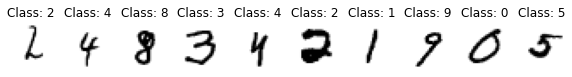

In [8]:
'''5. 데이터 확인하기(2)'''
pltSize=1
plt.figure(figsize=(10*pltSize,pltSize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap="gray_r")
    plt.title(f"Class: {str(y_train[i].item())}")

## 6.MLP (Multi Layer Perceptron) 설계
---

In [16]:
'''6. MLP (Multi Layer Perceptron) 설계'''
class Net(nn.Module):                       # PyTorch Module 내에 딥러닝 모델 관련 기본  함수를 포함하고 있는 nn.Module 클래스를 상속받는 Net 클래스 정의
    def __init__(self):
        super(Net, self).__init__()         # nn.Module 메서드 상속
        self.fc1 = nn.Linear(28*28, 512)    # Fisrt Fully Connected Layer : Input 크기 28*28*1 에 맞게 28*28 설정, Scond FCL이 512 input이므로 512 설정
        self.fc2 = nn.Linear(512, 256)      # Second Fully Connected Layer : 노드 수 512개로 설정, Third FCL를 256의 노드 수로 설정할 것이므로 256 설정
        self.fc3 = nn.Linear(256,10)        # Third Fully Connected Layer : 노드 수 256개 설정, Label 수에 맞게 끔 Output 10 설정
        
    def forward(self, x):                   # Net Class MLP Model의 Forward Propagation을 정의 (Output 계산까지의 과정 나열)
        x = x.view(-1, 28*28)               # MLP 모델의 입력은 1차원 인데 MNIST Set은 28*28로 2차원이므로 1차원으로 변환 해주는 View 메서드 (2차원을 1차원으로 펼친다 : Flatten)
        x = self.fc1(x)                     # __init__ 메서드를 이용해 First FCL에 1차원으로 펼친 이미지 데이터 통과
        x = F.sigmoid(x)                    # torch.nn.functional에 정의된 비선형 활성화 함수 sigmoid() 적용하여 Second FLC의 Input 계산
        x = self.fc2(x)                     # __init__ 메서드를 이용해 Second FCL에 sigmoid()로 활성화 된 Input data 통과
        x - F.sigmoid(x)                    # torch.nn.functional에 정의된 비선형 활성화 함수 sigmoid() 적용하여 Third FLC의 Input 계산
        x = self.fc3(x)                     # __init__ 메서드를 이용해 Third FCL에 sigmoid()로 활성화 된 Input data 통과
        x = F.log_softmax(x, dim=1)         # torch.nn.functional 내의 log.softmax()를 이용해 최종 output 계산
        return x

## **코드 과정 상세**

---
```python
class Net(nn.Module):
```
- PyTorch Module 내에 딥러닝 모델 관련 기본  함수를 포함하고 있는 nn.Module 클래스를 상속받는 Net 클래스 정의
<br><br>
---

```python
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,10)
```
- nn.Module 메서드 상속
- Fisrt Fully Connected Layer : Input 크기 28*28*1 에 맞게 28*28 설정, Scond FCL이 512 input이므로 512 설정
- Second Fully Connected Layer : 노드 수 512개로 설정, Third FCL를 256의 노드 수로 설정할 것이므로 256 설정
- Third Fully Connected Layer : 노드 수 256개 설정, Label 수에 맞게 끔 Output 10 설정
<br><br>  
---

```python
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x - F.sigmoid(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
```
- Net Class MLP Model의 Forward Propagation을 정의 (Output 계산까지의 과정 나열)
- MLP 모델의 입력은 1차원 인데 MNIST Set은 28*28로 2차원이므로 1차원으로 변환 해주는 View 메서드 (2차원을 1차원으로 펼친다 : Flatten)
- `__init__` 메서드를 이용해 First FCL에 1차원으로 펼친 이미지 데이터 통과
- `torch.nn.functional`에 정의된 비선형 활성화 함수 `sigmoid()` 적용하여 Second FLC의 Input 계산
- `__init__` 메서드를 이용해 Second FCL에 `sigmoid()`로 활성화 된 Input data 통과
- `torch.nn.functional`에 정의된 비선형 활성화 함수 `sigmoid()` 적용하여 Third FLC의 Input 계산
- `__init__` 메서드를 이용해 Third FCL에 `sigmoid()`로 활성화 된 Input data 통과
- `torch.nn.functional` 내의 `log.softmax()`를 이용해 최종 output 계산
    > `softmax()`가 아닌 `log.softmax()`를 사용하는 이유는 MLP 모델이 Back Propagation으로 학습을 진행할 때  
    > Loss 값에 대한 Gradient 값을 좀 더 원활하게 계산할 수 있기 때문  
    > log 함수 그래프의 기울기가 부드럽게 변화하는 것을 보면 직관적 이해 가능

## 7.Optimizer, Objective Function 설정
---

In [17]:
'''7. Optimizer, Objective Function 설정'''
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=.5)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


### **코드 과정 상세**
---
```python
model = Net().to(DEVICE)
```
- MLP 모델에 장비 할당
<br><br>
---

```python
optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=.5)
```
- Back Propagation을 이용해 파라미터 업데이트 시에 사용하는 Optimizer 정의
- SGD 알고리즘을 사용하고 `learning rate=0.01`, optimizer의 관성을 나타내는 `momentum=0.5` 부여
<br><br>
---

```python
criterion = nn.CrossEntropyLoss()
```
- output 값과 One-Hot Encoding의 값의 Loss는 `CrossEntropy`를 이용해 계산

## 8.MLP 모델 학습 시 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
---

In [15]:
'''8. MLP 모델 학습 시 학습 데이터에 대한 모델 성능을 확인하는 함수 정의'''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx*len(image),
                                                                                 len(train_loader.dataset), 100.*batch_idx/len(train_loader),
                                                                                 loss.item()))

## 9.학습 과정에서 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의
---

In [13]:
def evaluate(model, test_loader):
    model.eval()
    test_loss=0
    correct = 0
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

## 10.MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인
---

In [16]:
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} % \n".
    format(Epoch, test_loss, test_accuracy))

C:\Users\yunjc\anaconda3\envs\dl_env\lib\site-packages\torch\nn\functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000(0%)]	Train Loss: 2.298774
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 2.196892
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 2.150587
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 1.734314
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 1.296788
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 1.087169
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.582945
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.681578
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.384922
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.380759

[EPOCH: 1], 	Test Loss: 0.0170, 	Test Accuracy: 84.06 % 

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.649623
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.696271
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.468957
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.282265
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.267103
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.305264
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.328886
Train Epoch: 2 [44